# Sentiment Per Location 
Info on geopy: https://geopy.readthedocs.io/en/stable/

In [20]:
from pathlib import Path
from shapely.geometry import Point
import os
import sys
import csv
import geopandas as gpd
from geopy import geocoders
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [21]:
# Basic paths
project_path = Path().resolve().parent
csv_path = project_path / "data"

## Data

In [3]:
# Open in pandas the table with the sentiment and the location information
df_sen = pd.read_csv(csv_path/ "results_sa_all.txt")
df_sen

,title,date,stanza,textblob,vader,subjectivity
0,Prayer_Breakfast_2016,2016-02-04,0.099,0.178,1.000,0.542
1,Security_Team_Announcement,2008-12-01,0.140,0.162,0.998,0.403
2,Cairo_University,2009-06-04,-0.150,0.110,1.000,0.457
3,Umpqua_Community_College_Shootings,2015-10-01,-0.250,0.061,-0.998,0.435
4,White_House_Correspondent_Dinner_2013,2013-04-27,-0.012,0.145,1.000,0.501
...,...,...,...,...,...,...
341,Shimon_Peres_Memorial,2016-09-30,-0.083,0.164,1.000,0.436
342,ASEAN_Business_2015,2015-11-21,-0.050,0.164,1.000,0.399
343,Finance_Crisis_Fee,2010-01-14,-0.412,0.080,0.987,0.436
344,Oval_Office_Counter_Terrorism_Agenda,2015-12-06,-0.134,0.076,-1.000,0.398


In [5]:
# Call the all_speechs dataframe and clean it a bit
df_temp = pd.read_csv(csv_path / "all_speeches_cleaned.txt") 
df_temp = df_temp.drop(columns=["count_commas","content","date", "pages", "state"])
df_temp = df_temp[ df_temp["highest_speaker_count"] <= 3 ]
df_temp.head()

,title,location,highest_speaker_count,country,city,specific_location
1,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,USA,Washington D.C.,Washington Hilton
2,Security_Team_Announcement,"Chicago, Illinois",0,USA,Chicago,no_specific_location
3,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location
4,Umpqua_Community_College_Shootings,Washington D.C.,0,USA,Washington D.C.,no_specific_location
5,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,USA,Washington D.C.,Washington Hilton Hotel


In [6]:
# Merge the previous tables
df_cb = pd.merge(df_temp, df_sen, how='inner', on = 'title')
df_cb.head()

,title,location,highest_speaker_count,country,city,specific_location,date,stanza,textblob,vader,subjectivity
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,USA,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542
1,Security_Team_Announcement,"Chicago, Illinois",0,USA,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403
2,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457
3,Umpqua_Community_College_Shootings,Washington D.C.,0,USA,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,USA,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501


In [7]:
df4 = pd.read_csv(csv_path / "topic_classification.txt")
df4 = df4[['title', 'main_topic_1_index']]
df = pd.merge(df_cb, df4, how='inner', on='title')
df.head()

,title,location,highest_speaker_count,country,city,specific_location,date,stanza,textblob,vader,subjectivity,main_topic_1_index
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,USA,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,20
1,Security_Team_Announcement,"Chicago, Illinois",0,USA,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,9
2,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,21
3,Umpqua_Community_College_Shootings,Washington D.C.,0,USA,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,6
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,USA,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,22


# Get Coordinates of the City Names

In [8]:
# ⚠️ Running time about 5-6mins
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="seorin_kim")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df['geo_location'] = df['location'].apply(geocode)

df['point'] = df['geo_location'].apply(lambda loc: tuple(loc.point) if loc else None)
# Point = (latitude, longitude)

df.head()
    

,title,location,highest_speaker_count,country,city,specific_location,date,stanza,textblob,vader,subjectivity,main_topic_1_index,geo_location,point
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,USA,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,20,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)"
1,Security_Team_Announcement,"Chicago, Illinois",0,USA,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,9,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)"
2,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,21,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)"
3,Umpqua_Community_College_Shootings,Washington D.C.,0,USA,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,6,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)"
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,USA,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,22,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)"


In [9]:
df['geo_location'][0].raw.keys()

dict_keys(['place_id', 'licence', 'osm_type', 'osm_id', 'boundingbox', 'lat', 'lon', 'display_name', 'class', 'type', 'importance', 'icon'])

In [9]:
df['latitude'] = df['geo_location'].apply(lambda loc: loc.raw['lat'] if loc else None)
df['longitude'] = df['geo_location'].apply(lambda loc: loc.raw['lon'] if loc else None)
df.dtypes

title                     object
location                  object
highest_speaker_count      int64
country                   object
city                      object
specific_location         object
date                      object
stanza                   float64
textblob                 float64
vader                    float64
subjectivity             float64
main_topic_1_index         int64
geo_location              object
point                     object
latitude                  object
longitude                 object
dtype: object

In [10]:
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df.dtypes

title                     object
location                  object
highest_speaker_count      int64
country                   object
city                      object
specific_location         object
date                      object
stanza                   float64
textblob                 float64
vader                    float64
subjectivity             float64
main_topic_1_index         int64
geo_location              object
point                     object
latitude                 float64
longitude                float64
Coordinates               object
dtype: object

In [11]:
from shapely.geometry import Point
df["geometry"] = df["Coordinates"].apply(Point)
df.head()

,title,location,highest_speaker_count,country,city,specific_location,date,stanza,textblob,vader,subjectivity,main_topic_1_index,geo_location,point,latitude,longitude,Coordinates,geometry
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,USA,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,20,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.0452084 38.9165229)
1,Security_Team_Announcement,"Chicago, Illinois",0,USA,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,9,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)",41.875562,-87.624421,"(-87.6244212, 41.8755616)",POINT (-87.6244212 41.8755616)
2,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,21,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)",30.044388,31.235726,"(31.2357257, 30.0443879)",POINT (31.2357257 30.0443879)
3,Umpqua_Community_College_Shootings,Washington D.C.,0,USA,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,6,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)",38.895037,-77.036543,"(-77.0365427, 38.8950368)",POINT (-77.0365427 38.8950368)
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,USA,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,22,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.0452084 38.9165229)


In [12]:
df['country'] = df['country'].replace(['USA'], 'United States of America')

## World Map Data

In [13]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## GeoDataFrame

In [14]:
df['weighted'] = df['vader']*df['subjectivity']
df['main_topic_1_index'] = df['main_topic_1_index'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                                                            ['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8', 'Topic 9', 
                                                             'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15','Topic 16', 'Topic 17', 
                                                             'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23', 'Topic 24', 'Topic 25'])
df.rename(columns = {'main_topic_1_index': 'Topic'}, inplace=True)

gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
gdf

,title,location,highest_speaker_count,country,city,specific_location,date,stanza,textblob,vader,subjectivity,Topic,geo_location,point,latitude,longitude,Coordinates,geometry,weighted
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",0,United States of America,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,Topic 21,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.04521 38.91652),0.542000
1,Security_Team_Announcement,"Chicago, Illinois",0,United States of America,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,Topic 10,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)",41.875562,-87.624421,"(-87.6244212, 41.8755616)",POINT (-87.62442 41.87556),0.402194
2,Cairo_University,"Cairo, Egypt",0,Egypt,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,Topic 22,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)",30.044388,31.235726,"(31.2357257, 30.0443879)",POINT (31.23573 30.04439),0.457000
3,Umpqua_Community_College_Shootings,Washington D.C.,0,United States of America,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,Topic 7,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)",38.895037,-77.036543,"(-77.0365427, 38.8950368)",POINT (-77.03654 38.89504),-0.434130
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",0,United States of America,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,Topic 23,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.04521 38.91652),0.501000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Shimon_Peres_Memorial,"Mount Herzl, Jerusalem, Israel",0,Israel,Jerusalem,Mount Herzl,2016-09-30,-0.083,0.164,1.000,0.436,Topic 12,"(הר הרצל, הזיכרון, יפה נוף, ירושלים, נפת ירושל...","(31.772361150000002, 35.181634190650314, 0.0)",31.772361,35.181634,"(35.181634190650314, 31.77236115)",POINT (35.18163 31.77236),0.436000
342,ASEAN_Business_2015,"Shangri-La Hotel, Kuala Lumpur, Malaysia",0,Malaysia,Kuala Lumpur,Shangri-La Hotel,2015-11-21,-0.050,0.164,1.000,0.399,Topic 16,"(Shangri-La Hotel, 11, Jalan Sultan Ismail, Bu...","(3.1541698, 101.7064587, 0.0)",3.154170,101.706459,"(101.7064587, 3.1541698)",POINT (101.70646 3.15417),0.399000
343,Finance_Crisis_Fee,unknown_location,0,United States of America,Washington D.C.,White House,2010-01-14,-0.412,0.080,0.987,0.436,Topic 19,"(unknown, Gachoire Kiawambe, Nyanduma Sub Loc...","(-0.9999454, 36.7416612, 0.0)",-0.999945,36.741661,"(36.7416612, -0.9999454)",POINT (36.74166 -0.99995),0.430332
344,Oval_Office_Counter_Terrorism_Agenda,"White House, Washington D.C.",0,United States of America,Washington D.C.,White House,2015-12-06,-0.134,0.076,-1.000,0.398,Topic 4,"(White House, 1600, Pennsylvania Avenue Northw...","(38.897699700000004, -77.03655315, 0.0)",38.897700,-77.036553,"(-77.03655315, 38.8976997)",POINT (-77.03655 38.89770),-0.398000


# Where Were the Speeches of each Topic ?

https://plotly.com/python/scatter-plots-on-maps/

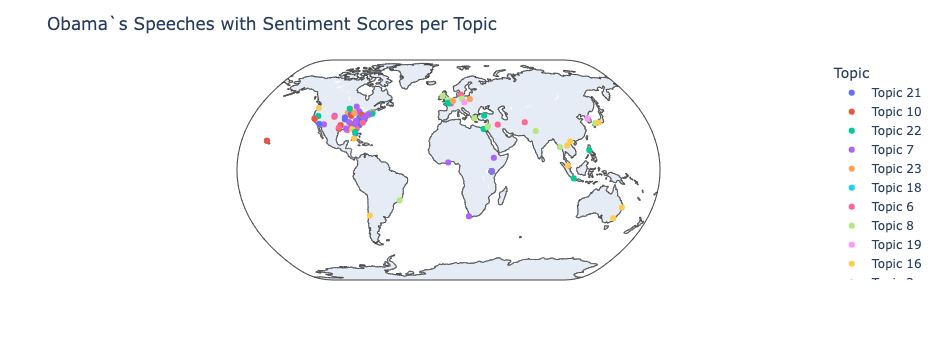

In [19]:
import plotly.express as px
# df = px.data.gapminder().query("year==2007")
fig = px.scatter_geo(gdf, lat="latitude", lon="longitude",  color = "Topic",
                      hover_name="title",
                     hover_data= {"latitude": False,
                                  "longitude": False,
                                  "location": True,
                                  "stanza": True},
                     projection="natural earth")

fig.update_layout(
        title_text = 'Obama`s Speeches with Sentiment Scores per Topic',
        showlegend = True
    )
fig.show()

# Sentiments Per Country

The following map shows the weighted sentiment scores using Vader which fluctuates between -1 (negative) and 1 (positive). 

In [22]:
colors={'Topic 1': '#FD3216', 'Topic 2': '#00FE35', 'Topic 3': '#6A76FC', 'Topic 4': '#FED4C4', 'Topic 5': '#FE00CE', 
        'Topic 6':'#0DF9FF', 'Topic 7': '#F6F926', 'Topic 8': '#FF9616', 'Topic 9': '#479B55', 'Topic 10': '#EEA6FB',
        'Topic 11':'#DC587D','Topic 12':'#D626FF', 'Topic 13':'#6E899C', 'Topic 14':'#00B5F7', 'Topic 15': '#B68E00', 
        'Topic 16':'#C9FBE5', 'Topic 17':'#FF0092', 'Topic 18':'#22FFA7', 'Topic 19':'#E3EE9E', 'Topic 20':'#86CE00',
        'Topic 21': '#BC7196', 'Topic 22': '#7E7DCD', 'Topic 23': '#FC6955', 'Topic 24': '#E48F72', 'Topic 25':'#9467FD'}

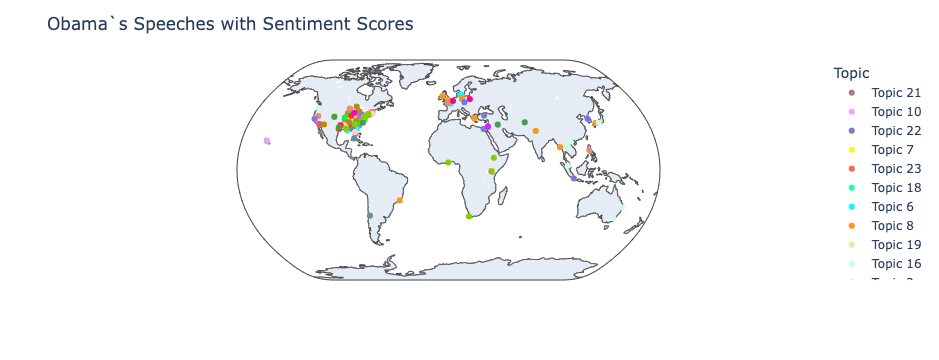

In [44]:
import plotly.express as px
# df = px.data.gapminder().query("year==2007")
fig = px.scatter_geo(gdf, lat="latitude", lon="longitude",  color = 'Topic', color_discrete_map = colors, #or color='stanza'
                      hover_name="title",
                     hover_data= {"latitude": False,
                                  "longitude": False,
                                  "location": True,
                                  "stanza": True},
                     projection="natural earth")

fig.update_layout(
        title_text = 'Obama`s Speeches with Sentiment Scores',
        showlegend = True,
    
# Layout of legend for the slides
#         legend=dict(
#             orientation="h",
#             yanchor="bottom",
#             y= -1,
#             xanchor="right",
#             x=1.3)
)

fig.show()
